# US Demographics Data

## Imports

In [1]:
import pandas as pd
import seaborn as sns
import ipyleaflet as ipyl
import geopandas as gpd
import matplotlib
import ipywidgets as widgets
from ipywidgets import HTML
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from shapely.geometry import Polygon
from matplotlib.colors import LogNorm
from shapely.geometry import mapping, MultiPolygon, Polygon
from branca.colormap import linear, LinearColormap
import folium
from folium import plugins
from io import BytesIO
import binascii
from matplotlib.cm import get_cmap
from PIL import Image
from typing import Iterable

## Constants

In [2]:
out_dir = 'out/'
data_dir = 'data/'

## Load Demographics Data

Taken from the National Bureau of Economic Research Census data: 

https://data.nber.org/census/popest/countypopmonthasrh.csv

In [3]:
data = pd.read_csv(data_dir+'countypopmonthasrh.csv')
data = data[data.yearref > 2]

## Load County Shapes

Taken from the 2017 census TIGER files:

https://www2.census.gov/geo/tiger/TIGER2017/COUNTY/tl_2017_us_county.zip

In [4]:
county_shapes = gpd.read_file(data_dir+'tl_2017_us_county').dropna(subset=['GEOID'])
county_shapes.GEOID = county_shapes.GEOID.astype(np.int64)
county_shapes['area'] = (county_shapes.ALAND + county_shapes.AWATER) / 1E6
county_shapes.geometry = county_shapes.geometry.simplify(.01)

In [5]:
data = gpd.GeoDataFrame(data.merge(county_shapes[['GEOID', 'geometry', 'area']], 
                                   left_on='county', right_on='GEOID'))
data.crs = county_shapes.crs

## Data Preprocessing

In [6]:
data_agg = data[data.agegrp == 0].copy()
data = data[data.agegrp > 0]

In [7]:
age_groups= {1: 0,
 2: 5,
 3: 10,
 4: 15,
 5: 20,
 6: 25,
 7: 30,
 8: 35,
 9: 40,
 10: 45,
 11: 50,
 12: 55,
 13: 60,
 14: 65,
 15: 70,
 16: 75,
 17: 80,
 18: 85}

In [8]:
data.agegrp = data.agegrp.replace(age_groups)

## Preparing Data for 2016

In [13]:
data_2016 = data[data.year == 2016].copy()
data_2016_agg = data_agg[data_agg.year == 2016].copy()
data_2016_agg['female_percentage'] = np.round(data_2016_agg.tot_female / data_2016_agg.tot_pop * 100, 2)

## Plotting Function

In [ ]:
def bbox_to_polyon(min_x, min_y, max_x, max_y):
    return Polygon([(min_x, min_y), (max_x, min_y), (max_x, max_y), (min_x, max_y)])

def plot_geo_df(geo_df, value_col, cmap='RdBu', vmin=0, vmax=1, ax=None, cax=None, legend=False,
               plot_kwargs = {}):
    if ax is None:
        fig, ax = plt.subplots()
        
    if legend and cax is None:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="2%", pad=0.1)

    geo_df.plot(value_col, cmap=cmap, vmin=vmin, vmax=vmax, ax=ax, legend=legend, cax=cax, **plot_kwargs)
    geo_df.boundary.plot(ax=ax, color='black', linewidth=.25, alpha = .25)
    ax.axis('off')

In [ ]:
def plot_us_data(geo_df, column, title, center=50, cmap='RdBu_r', logarithmic = False):
    fig, ax1 = plt.subplots(1, figsize=(20,20), dpi=200)
    fig.patch.set_facecolor('#f5f5f5'), fig.patch.set_alpha(1)
    ax1.set_title(title)
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="1.5%", pad=0.1)
    ax2 = inset_axes(ax1, width="30%", height="30%", loc=3)

    alaska = geo_df[geo_df.geometry.within(bbox_to_polyon(-179, 50, -125, 72))]
    continental_us = geo_df[geo_df.geometry.within(bbox_to_polyon(-126, 23, -66,  50))]

    if center is None:
        vmin, vmax = geo_df[column].min(), geo_df[column].max()
    else:
        rng = np.max(np.abs(geo_df[column] - center))
        vmin, vmax = center-rng, center+rng
    
    plot_kwargs = dict(norm=LogNorm(vmin=vmin, vmax=vmax)) if logarithmic else {}
    plot_geo_df(continental_us, column, ax=ax1, legend=True, cax=cax, vmin=vmin, vmax=vmax, cmap=cmap,
               plot_kwargs=plot_kwargs)
    plot_geo_df(alaska, column, ax=ax2, vmin=vmin, vmax=vmax, cmap=cmap,
               plot_kwargs=plot_kwargs)

## Percentage of female population

In [ ]:
plot_us_data(data_2016_agg, 'female_percentage', 'Percentage of female population in US counties')
plt.savefig(out_dir + 'female_percentage.png')

## Population

In [ ]:
plot_us_data(data_2016_agg, 'tot_pop', 'Population per US county', cmap='viridis', center=None, logarithmic=True)
plt.savefig(out_dir + 'population.png')

## Interactive Plotting

### Tooltip Heatmap Plots

In [10]:
def plot_choro_heatmap(df, ax, cmap, vmin, vmax, choro_col='female_percentage', x_col='year', y_col='agegrp'):
    heatmap_data = df.pivot(columns=x_col, index=y_col, values=choro_col)
    sns.heatmap(heatmap_data, cmap=cmap, vmin=vmin, vmax=vmax, ax=ax, rasterized=True)
    plt.tight_layout()
    plt.ylim(len(df[y_col].unique()), 0)
    
def get_ethnicity_df(df):
    ethnicities = {'wa': 'white', 'ba':'black', 'ia':'native', 'aa':'asian', 'na':'pacific', 'h': 'hisp.'}
    eth_df = df[df.year == df.year.max()][['agegrp']].copy()
    for eth, name in ethnicities.items():
        eth_df[name] = (df[eth+'_female'] + df[eth+'_male'])
    return eth_df.groupby(['agegrp']).sum().reset_index()

def plot_ethnicities_heatmap(df, ax, cmap='viridis', cbar_ax = None, **_):
    eth_df = get_ethnicity_df(df)
    eth_df_melted = eth_df.melt(id_vars=('agegrp', ), var_name='ethnicity')
    heatmap_data=eth_df_melted.pivot(columns='ethnicity', index='agegrp', values='value')
    sns.heatmap(heatmap_data, cmap=cmap, rasterized=True, ax=ax, cbar_ax=cbar_ax)
    print(heatmap_data.shape)
    plt.ylim(heatmap_data.shape[0], 0)
    

def get_heatmap_plot(df, plotting_fun, vmin=None, vmax=None, cmap='viridis', svg=False, figsize=(3.25, 2.75), 
                     colorspace_compression=True, **kwargs):
    def encode_plot_png(fig: plt.Figure):
        if colorspace_compression:
            with BytesIO() as buf:
                plt.savefig(buf, format='png')
                buf.seek(0)
                im = Image.open(buf)
                # convert to 8bit
                im2 = im.convert('RGB').convert('P', palette=Image.ADAPTIVE)
            with BytesIO() as buf2:
                im2.save(buf2 , format='PNG')
                img_data = binascii.b2a_base64(buf2.getvalue()).decode()
        else:
            with BytesIO() as buf:
                fig.canvas.print_png(buf, transparent=True)
                img_data = binascii.b2a_base64(buf.getvalue()).decode()
        
        img_html = '<img src="data:image/png;base64,{}">'.format(img_data)
        return img_html
    
    def encode_plot_svg(fig: plt.Figure):
        with BytesIO() as buf:
            plt.savefig(buf, format='svg')
            img_data = buf.getvalue().decode()
        return img_data
    
    fig, ax = plt.subplots(figsize=figsize) 
    plotting_fun(df, ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, **kwargs)
    plt.tight_layout()
    img_data = encode_plot_svg(fig) if svg else encode_plot_png(fig)
    plt.close(fig)
    return img_data

### Plotting Function

In [11]:
def get_choropleth_layer(geo_df: gpd.GeoDataFrame, choro_col: str, name_col: str, 
                         colormap, name: str = '', vmin=0, vmax=1, id_col: str='county'):

    def create_geo_data(df: gpd.GeoDataFrame):
        return ipyl.GeoData(geo_dataframe=df).data
    
    def get_style(feature):
        return {'fillColor': colormap(feature['properties'][choro_col]), 'color': 'grey', 'weight': .1, 
                'lineOpacity': .4, 'fillOpacity': .8}
    
    def get_hover_style(feature):
        return {'fillColor': colormap(feature['properties'][choro_col]), 
                'lineOpacity': 1, 'fillOpacity': 1}

    geo_json_data = create_geo_data(geo_df)
    tooltip_cols = [name_col, 'population', choro_col]
    tooltip_aliases = [c.replace('_percentage', ' %').replace('_', '<br/>') for c in tooltip_cols]
    if 'img' in geo_df.columns:
        tooltip_aliases, tooltip_cols = [*tooltip_aliases, ''], [*tooltip_cols, 'img']
    
    tooltip=folium.features.GeoJsonTooltip(fields= tooltip_cols, aliases= tooltip_aliases)
    
    layer = folium.GeoJson(ipyl.GeoData(geo_dataframe=geo_df).data, highlight_function=get_hover_style,
        name=name, smooth_factor=0, tooltip=tooltip, style_function=get_style)

    return layer

def plot_us_data_map(df, choro_column = 'female_percentage', layers_column = 'year', m=None, name:str=None,
                    vmin = 0, vmax=1, layer_val = 2016, name_column = 'ctyname', choro_fun=None, cmap='viridis',
                    plotting_fun=plot_choro_heatmap, log_scaling=False, **plotting_fun_kwargs):
    def add_plots():
        for county in df.county.unique():
            plots[county]=[]
            for fun in plotting_fun:
                indexer = df.county == county
                county_df = df[indexer]
                img = get_heatmap_plot(county_df, vmin=vmin, vmax=vmax, cmap=cmap, plotting_fun=fun,
                                      choro_col=choro_column, **plotting_fun_kwargs)
                plots[county].append(img)
            plots[county] = '<br/>'.join(plots[county])
    
    if m is None:
        m = folium.Map(location=[48, -102], zoom_start=3)
        
    mp_colormap = get_cmap(cmap)
    samples = np.linspace(vmin, vmax, 20)
    samples_scaled = np.logspace(np.log10(vmin), np.log10(vmax), 20) if log_scaling else samples
    colors = [mp_colormap((s-vmin)/(vmax-vmin)) for s in samples]
    colormap = LinearColormap(colors=colors, index=samples_scaled, vmin=vmin,vmax=vmax)
    
    if plotting_fun is not None:
        if choro_fun != None:
            df[choro_column] = choro_fun(df)
        plots = {}
        if not isinstance(plotting_fun, Iterable):
            plotting_fun = [plotting_fun]
        add_plots()
        

    layer_df = df[df[layers_column] == layer_val]
    grouped = layer_df.groupby('county')
    layer_df_agg = gpd.GeoDataFrame(grouped.sum())
    layer_df_agg['ctyname'] = grouped.ctyname.first()
    layer_df_agg['geometry'] = grouped.geometry.first()
    layer_df_agg['population'] = layer_df_agg['tot_pop']
    layer_df_agg['area'] = grouped.area.first()
    
    if choro_fun != None:
        layer_df_agg[choro_column] = choro_fun(layer_df_agg)

    layer_df_agg.crs = df.crs
    layer_df_agg.reset_index(inplace=True)
    
    columns = ['geometry', choro_column, name_column, 'population']
    
    if plotting_fun is not None:
        layer_df_agg['img'] = layer_df_agg.county.apply(lambda c: plots[c])
        columns.append('img')

    if name in (None, ''):
        name = '{} {}'.format(layers_column, layer_val).replace('_', ' ')
        
    layer = get_choropleth_layer(layer_df_agg[columns], choro_col=choro_column, name_col = name_column,
                                name=name, colormap=colormap, vmin=vmin, vmax=vmax)
    layer.add_to(m)
        
    m.add_child(colormap)
    folium.LayerControl().add_to(m)
    plugins.Fullscreen().add_to(m)
    
    return m

## Gender Balance

KeyboardInterrupt: 

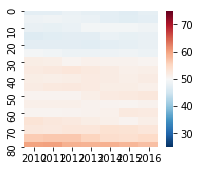

In [186]:
def get_female_percentage(df):
    return round(df.tot_female / df.tot_pop * 100, 2)

m_gender_balance = plot_us_data_map(data, vmin=25, vmax=75, choro_column = 'female_percentage',
                                   choro_fun = get_female_percentage, cmap='RdBu_r', name='female percentage',
                                   plotting_fun = plot_choro_heatmap)

In [ ]:
m_gender_balance.save(out_dir + 'gender_balance_2016.html')

In [ ]:
grouped = data.groupby(['year', 'agegrp'])
overall_gender_balance_df = get_female_percentage(grouped.sum()).reset_index().rename({0: 'female_percentage'}, 
                                                                                      axis='columns')
rng = np.max(np.abs(overall_gender_balance_df.female_percentage - 50))
plt.figure(figsize=(17,6), dpi = 150)
plt.title('Percent of female Population')
sns.heatmap(overall_gender_balance_df.pivot(index='year', columns='agegrp', values='female_percentage'),
           annot=True, cmap='RdBu_r', vmin = 50-rng, vmax=50+rng, fmt='.3g', linewidths=1)

b, t = plt.ylim()
plt.ylim(b+.5, t-.5)
plt.savefig(out_dir + 'gender_balance_overall.svg')

## Population Ethnicity

In [25]:
def get_ethnic_percentage(df):
    return round((1 - (df.wa_male + df.wa_female) / df.tot_pop) * 100, 2)

m_ethnic = plot_us_data_map(data, vmin=0, vmax=100, choro_column = 'ethnic_percentage', 
                            name='ethnic percentage', choro_fun = get_ethnic_percentage, cmap='magma_r', 
                            plotting_fun=plot_ethnicities_heatmap)

In [ ]:
m_ethnic.save(out_dir + 'ethnic_pop_2016.html')

In [ ]:
grouped = data.groupby(['year', 'agegrp'])
overall_ethnic_df = get_ethnic_percentage(grouped.sum()).reset_index().rename({0: 'ethnic'}, 
                                                                                      axis='columns')
plt.figure(figsize=(17,6), dpi = 150)
plt.title('Percent of ethnic Population')
sns.heatmap(overall_ethnic_df.pivot(index='year', columns='agegrp', values='ethnic'),
           annot=True, cmap='magma_r', fmt='.3g', linewidths=1)

b, t = plt.ylim()
plt.ylim(b+.5, t-.5)
plt.savefig(out_dir + 'ethnic_pop_overall.svg')

## Population Density

In [12]:
def get_pop_density(df):
    return round(df.tot_pop / df['area'], 1)

grouped = data[data.year == 2016].groupby('ctyname')
densities = grouped.tot_pop.sum() / grouped['area'].first()
vmin, vmax = densities.min(), densities.max()

m_pop = plot_us_data_map(data, choro_column = 'population_density', vmin=0.1, vmax=vmax,
                            name='population density<br>log scaled', choro_fun = get_pop_density, cmap='inferno_r', 
                            plotting_fun=None, log_scaling=True)

In [13]:
m_pop.save(out_dir + 'population_density_2016.html')